<a href="https://colab.research.google.com/github/IvashchenkoDR/Stat_prak/blob/main/Home_work4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework


The homework is to prepare a report for the Ministry of Transport, revealing the nature and characteristics of flight delays. The report should help identify problem areas and contribute to decision-making. Therefore, strive not to state general facts, but to show problems. For example, the fact "the average departure delay is 15 minutes" by itself says little and does not help to understand why this is happening. On the contrary, a graph showing that on Mondays delays increase threefold compared to other days against the background of an increase in the number of flights and passengers suggests a possible cause of the problem: airports cannot cope with uneven load.

The report should be in the form of a notebook with a clear structure. At the beginning of the Markdown cell there is a brief description of the question under study (what we will study), then the code and all its outputs (tables, graphs, values), then again in the Markdown cell in which your brief conclusion is formulated.

The report should contain at least **5 results** confirmed by graphs. For variety of material, use different types of diagrams. All graphs should be provided with the necessary signatures (axis designations, title, color scheme legend).

To solve the problems, use the methods of the `pandas` library.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/My Drive/datasets/flights.csv', low_memory=False)
airport_df = pd.read_csv('/content/drive/My Drive/datasets/airports.csv')

In [ ]:
airlines_df = pd.read_csv('/content/drive/My Drive/datasets/airlines.csv')

# 1. Анализ задержек по аэропортам (прибытие и вылет)

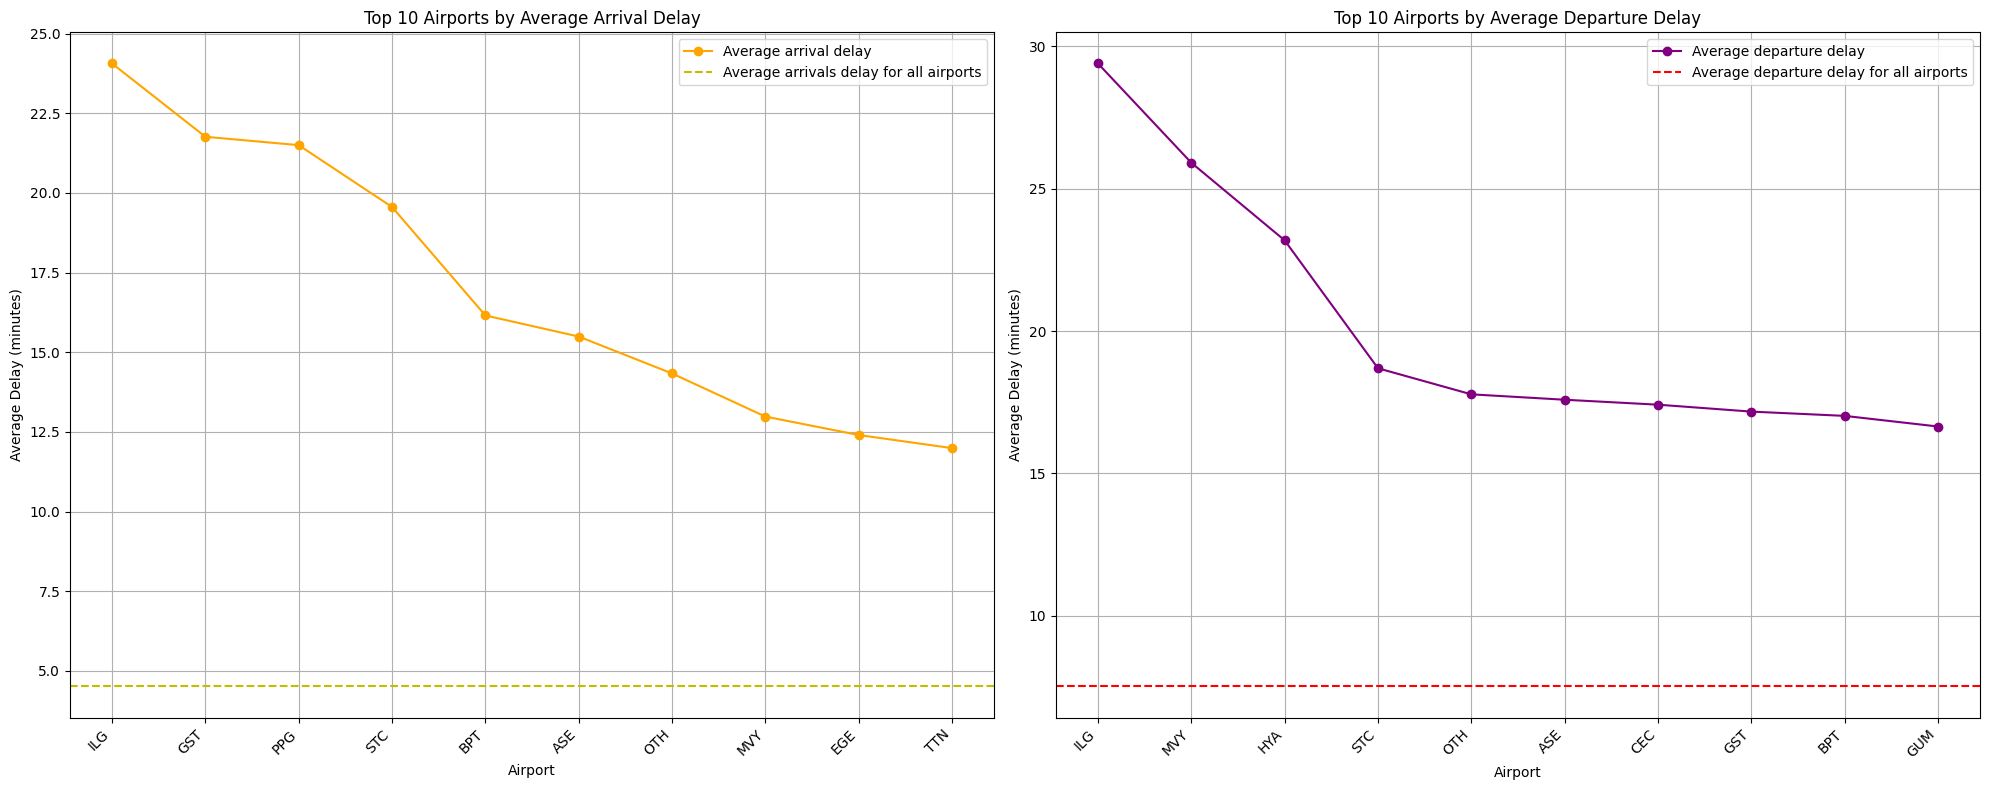

In [ ]:
filtered_df = df[~df['ORIGIN_AIRPORT'].str.match(r'^\d+$')] #оставляет строки, где ORIGIN_AIRPORT не состоит только из цифр

iata_to_airport = dict(zip(airport_df['IATA_CODE'], airport_df['AIRPORT']))

airport_delay_stats = filtered_df.groupby('ORIGIN_AIRPORT').agg({
    'ARRIVAL_DELAY': 'mean',
    'DEPARTURE_DELAY': 'mean'
})

worst_airports_arrival = airport_delay_stats.nlargest(10, 'ARRIVAL_DELAY')
worst_airports_arrival['AIRPORT'] = worst_airports_arrival.index.map(iata_to_airport)

worst_airports_departure = airport_delay_stats.nlargest(10, 'DEPARTURE_DELAY')
worst_airports_departure['AIRPORT'] = worst_airports_departure.index.map(iata_to_airport)

plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.plot(worst_airports_arrival.index, worst_airports_arrival['ARRIVAL_DELAY'],
         marker='o', color='orange', label='Average arrival delay')
plt.axhline(y=airport_delay_stats['ARRIVAL_DELAY'].mean(),
            color='y', linestyle='--', label='Average arrivals delay for all airports')
plt.title('Top 10 Airports by Average Arrival Delay')
plt.xlabel('Airport')
plt.ylabel('Average Delay (minutes)')
plt.xticks(rotation=45, ha='right')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(worst_airports_departure.index, worst_airports_departure['DEPARTURE_DELAY'],
         marker='o', color='purple', label='Average departure delay')
plt.axhline(y=airport_delay_stats['DEPARTURE_DELAY'].mean(),
            color='r', linestyle='--', label='Average departure delay for all airports')
plt.title('Top 10 Airports by Average Departure Delay')
plt.xlabel('Airport')
plt.ylabel('Average Delay (minutes)')
plt.xticks(rotation=45, ha='right')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


По данным видно, что аэропорты ILG, STC, GST, PPG, MVY и HYA сильно отстают от среднего времени задержек. Чтобы улучшить ситуацию, стоит увеличить интервалы между рейсами в этих аэропортах. Особенно плохо обстоят дела в аэропортах ILG и STC — у них большие задержки и по прилётам, и по вылетам, что говорит о том, что они не справляются с нагрузкой.

# 2. Анализ причин задержек

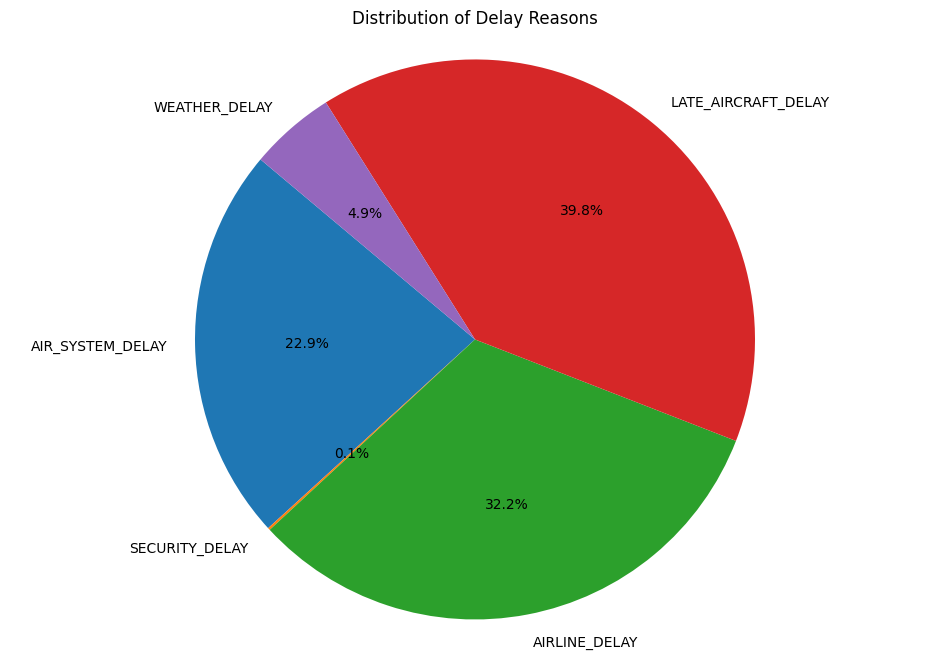

In [ ]:
delay_reasons = ['AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']
frequency = df[delay_reasons].sum()

plt.figure(figsize=(12, 8))
plt.pie(frequency, labels=delay_reasons, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Distribution of Delay Reasons')
plt.show()

По круговой диаграмме можно сделать вывод, что наиболее частые задержки происходят из-за системы воздушного пространства.

# 3. Анализ задержек по авиакомпаниям

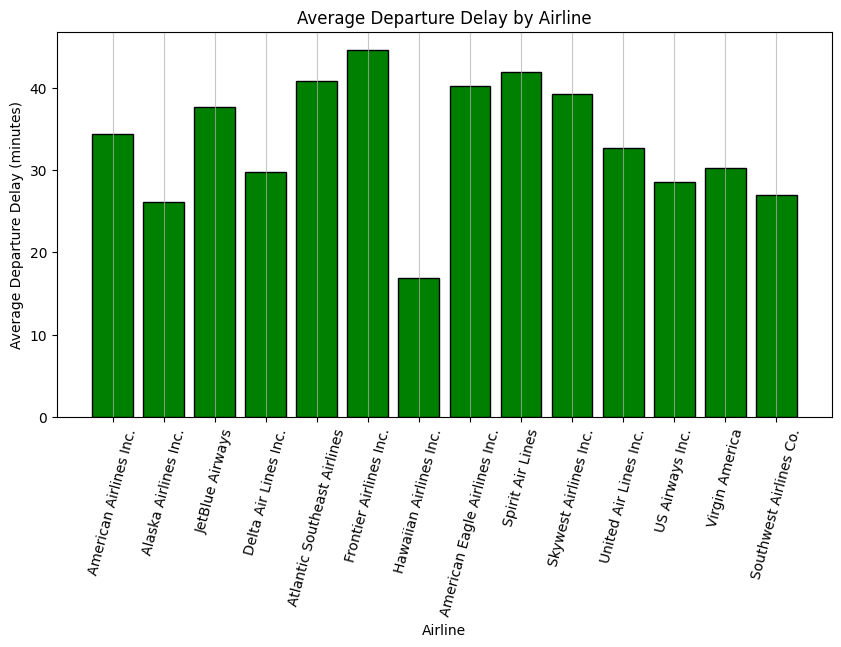

In [ ]:
df_filtered = df[df['DEPARTURE_DELAY'] > 0]

airline_delays = df_filtered.groupby('AIRLINE')['DEPARTURE_DELAY'].mean().reset_index()

code_to_name = dict(zip(airlines_df['IATA_CODE'], airlines_df['AIRLINE']))

df_filtered.index = df_filtered.index.map(code_to_name)

airline_delays['AIRLINE'] = airline_delays['AIRLINE'].map(code_to_name)

plt.figure(figsize=(10, 5))
plt.bar(airline_delays['AIRLINE'], airline_delays['DEPARTURE_DELAY'], color ='green', edgecolor='black')
plt.title('Average Departure Delay by Airline')
plt.xlabel('Airline')
plt.ylabel('Average Departure Delay (minutes)')
plt.grid(axis = 'x', alpha = 0.7)
plt.xticks(rotation=75)
plt.show()

Мы можем наблюдать, что среднее время задержки для Hawaiian Airlines Inc. составляет менее 10 минут, что позволяет сделать вывод о том, что это самая пунктуальная авиакомпания.

# 4. Сравнение среднего времени задержки по разным причинам

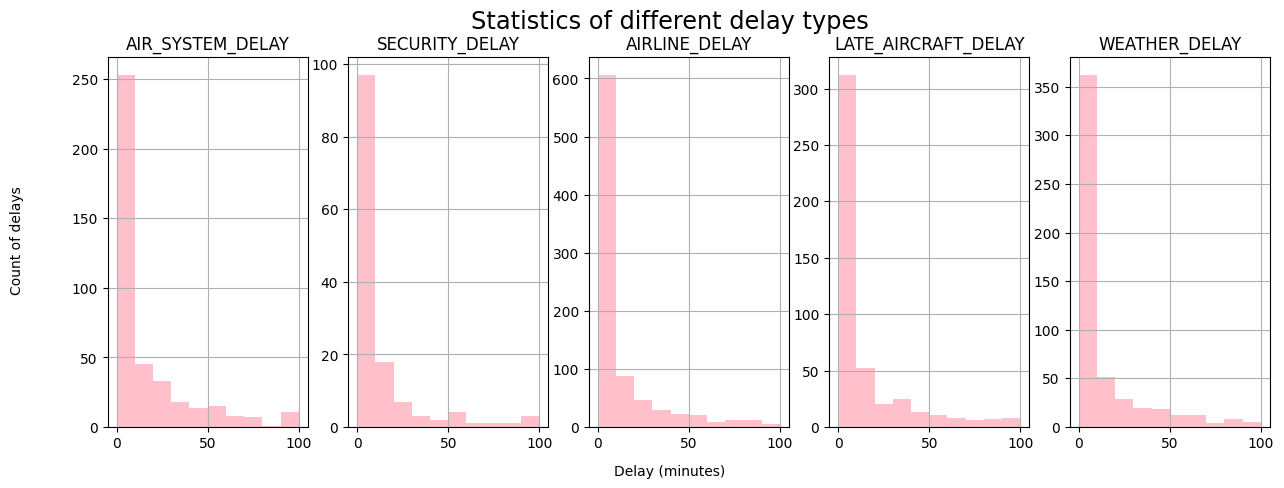

In [ ]:
df = df.loc[~df[['AIR_SYSTEM_DELAY', "SECURITY_DELAY", "AIRLINE_DELAY", "LATE_AIRCRAFT_DELAY", "WEATHER_DELAY"]].isna().any(axis=1)]
delay_types = ['AIR_SYSTEM_DELAY', "SECURITY_DELAY", "AIRLINE_DELAY", "LATE_AIRCRAFT_DELAY", "WEATHER_DELAY"]
delays = []
delaylist = []

fig, axes = plt.subplots(1, 5)
fig.set_figwidth(15)
count = 0
for name in delay_types:
    delaylist = df[name].value_counts()
    delaylist.sort_values()
    dx = delaylist.hist(ax = axes[count], range = (0, 100), color = "pink")
    dx.set_title(name)
    count += 1

fig.text(0.5, 0.01, "Delay (minutes)", ha='center')
fig.text(0.06, 0.5, 'Count of delays', va='center', rotation='vertical')
plt.suptitle('Statistics of different delay types', ha='center', fontsize='xx-large')
plt.show()

Задержки из-за погоды или по вине авиакомпании обычно быстро уменьшаются со временем, потому что есть четкие правила и всё под контролем. А вот задержки из-за технических проблем или опоздания предыдущего рейса не уменьшаются, даже если они становятся дольше. Это говорит о том, что нужно лучше организовать работу персонала в таких ситуациях.

# 5. Анализ задержек по месяцам

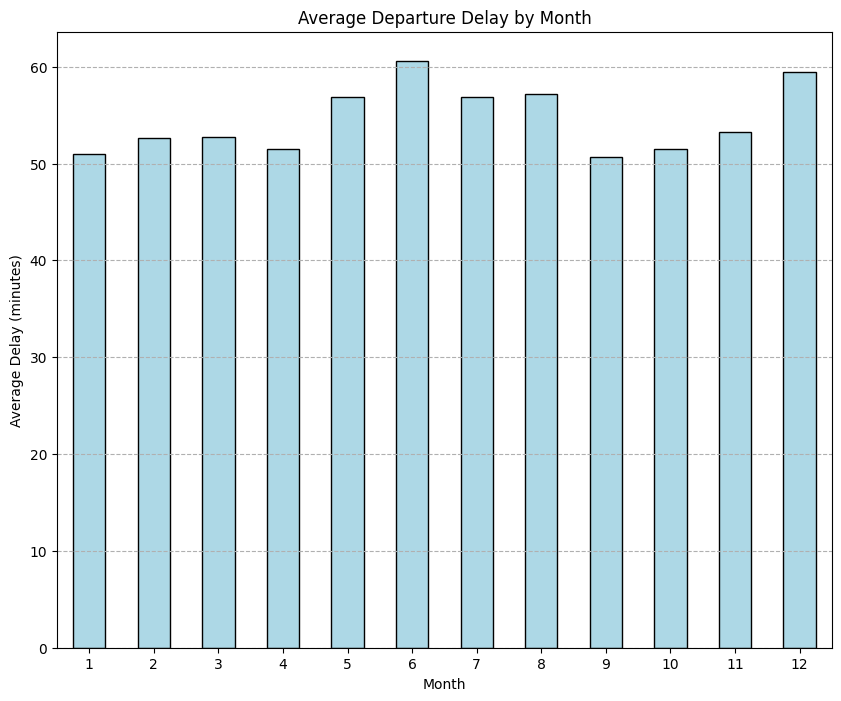

In [ ]:
monthly_delays = df.groupby('MONTH')['DEPARTURE_DELAY'].mean()

plt.figure(figsize=(10, 8))
monthly_delays.plot(kind='bar', color='lightblue', edgecolor='k')
plt.title('Average Departure Delay by Month')
plt.xlabel('Month')
plt.ylabel('Average Delay (minutes)')
plt.grid(axis='y', linestyle='--')
plt.xticks(rotation=0)
plt.show()

В летние месяцы задержка возрастает, возможно это связано с тем, что люди в большом количестве улетают в отпуск. Также в декабре увеличиваются задержки, возможно это связано с Новым годом и Рождеством. В эти месяцы нужно увеличивать количество принимаемых рейсов, чтобы уменьшить задержку.